In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import pickle
root = '../dataset/hi'
root_soh = '../dataset/soh_charge'
root_model = '../model'


In [2]:

def load_and_process(root, root_soh, dataset):
    hiv = pd.read_csv(f'{root}/hiv-charge-CS2_{dataset}.csv')
    soh = pd.read_csv(f'{root_soh}/Csoh-CS2_{dataset}.csv')

    # Mantieni solo le colonne da hiv e soh
    df = pd.merge(hiv, soh, how="right", on="cycle")[["cycle", "hi_v", "SOH"]]
 
    df_cycle = df[["cycle"]]
    df = df.drop(columns=["cycle"])
    df_hiv = df[["hi_v"]]
    df_soh = df[["SOH"]]
    return df_hiv.values, df_soh.values, df_cycle.values 

# Carica e processa i dataset
df_33_hiv, df_33_soh, df_33_cycle = load_and_process(root, root_soh, 33)
df_35_hiv, df_35_soh, df_35_cycle = load_and_process(root, root_soh, 35)
df_37_hiv, df_37_soh, df_37_cycle = load_and_process(root, root_soh, 37)
df_36_hiv, df_36_soh, df_36_cycle = load_and_process(root, root_soh, 36)
df_38_hiv, df_38_soh, df_38_cycle = load_and_process(root, root_soh, 38)


In [3]:
print(df_35_hiv.shape, df_35_soh.shape, df_35_cycle.shape)

(797, 1) (797, 1) (797, 1)


In [4]:
cycle_add = 10
seq_length = 10+cycle_add


def split_sequence(data, seq_length, train=False):
    seq = []   
    for j in data:
        for i in range(len(j) - seq_length):
            if train:
                seq.append(j[i:i+seq_length - cycle_add])
                # print(j[i:i+seq_length])
            else:
                seq.append(j[i+seq_length ])
                # print(i+seq_length, i+seq_length+cycle_add)
                # print(i+seq_length)
    if train:
        return np.array(seq)
    else:
        return np.array(seq)
# y_train = split_sequence([df_36_soh, df_38_soh], seq_length)

# def split_sequence(data, seq_length, n_steps, train=False):
#     X, y = [], []
#     for j in data:
#         for i in range(len(j) - seq_length - n_steps + 1):
#             seq_x, seq_y = j[i:i+seq_length], j[i+seq_length:i+seq_length+n_steps]
#             X.append(seq_x)
#             if train:
#                 y.append(seq_y)
#     return np.array(X), (np.array(y) if train else None)


In [5]:
print(df_36_soh.shape, df_38_soh.shape)

(827, 1) (904, 1)


In [6]:
# Create sequences for training set
# n_steps = 5
X_train = split_sequence([df_36_hiv, df_38_hiv], seq_length, train=True)
y_train = split_sequence([df_36_soh, df_38_soh], seq_length)
# print(X_train)
# Calculate mean and std for normalization
mean = X_train.mean()
std = X_train.std()

# Standardize train data
X_train = (X_train - mean) / std

# Shuffle the sequences
perms = np.random.permutation(len(X_train))
X_train = X_train[perms]
y_train = y_train[perms]


print(X_train.shape, y_train.shape)

(1691, 10, 1) (1691, 1)


In [7]:
X_train.shape

(1691, 10, 1)

In [8]:
# load the data
trainLen = len(X_train)
# testLen = len(X_test)
initLen = 100
print(trainLen, initLen)

1691 100


In [9]:
class ESN:
    def __init__(
            self,
            inSize= 1,
            outSize = 1,
            resSize = 100,
            a = 1,
            seed = 42,
            spectral_radius = .9,
            reg = 1e-4
            ):
        self.inSize = inSize
        self.outSize = outSize
        self.resSize = resSize
        self.a = a
        self.reg = reg
        np.random.seed(seed)
        self.Win = (np.random.rand(self.resSize,inSize) - 0.5) * 2
        self.res_bias = (np.random.rand(self.resSize,1) - 0.5) * 2
        self.W = (np.random.rand(resSize,resSize) - 0.5) * 2
        rhoW = np.max(np.abs(np.linalg.eigvals(self.W)))
        self.W *= spectral_radius / rhoW
        

    def res_forward(self, X_train):
        # H = []
        n_example = X_train.shape[0]
        # for j in range(n_example):
        h = np.zeros((self.resSize, n_example))
        res_bias = np.repeat(self.res_bias, n_example, axis=1)
        for t in range(X_train.shape[1]):
            # (n_example, inSize)
            x = X_train[:,t]
            # (resSize, n_example) = (resSize, inSize) * (inSize, n_example) + (resSize, resSize) * (resSize, n_example) + (resSize, n_example) 
            h_temp =  np.tanh(self.Win @ x.T + self.W @ h + res_bias)
            #(resSize, n_example) = (resSize, n_example) + (resSize, n_example) 
            h = (1-self.a)*h + self.a*h_temp
        # H.append(h.T)
        # (n_example, resSize)
        return h.T
    
    def fit(self, X_train, y_train):
        H = self.res_forward(X_train)
        Y = y_train
        I = np.eye(self.resSize)
        # (resSize, outSize) = ((resSize, n_example) * (n_example, resSize) + (resSize, resSize)) * (resSize, n_example) * (n_example, outSize)
        self.Wout = np.linalg.inv( H.T @ H + self.reg*I) @ H.T @ Y 
        
    def predict(self, X_test):
        H = self.res_forward(X_test)
        #(n_examples, outSize) = (n_example, resSize) *  (resSize, outSize)
        o = H @ self.Wout
        return o
    


In [10]:
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.model_selection import train_test_split

# Define hyperparams for grid search
param_grid = {
    'resSize': [50, 100, 200],
    'spectral_radius': [0.8, 0.9, 1.0],
    'reg': [1e-4, 1e-5, 1e-6],
    'a': [0.1, 0.3, 0.5]
}

# Create GridSearch
grid = ParameterGrid(param_grid)

# Initialize best params
best_mae = float('inf')
best_params = None

# Divide datas into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
# grid_result = grid.fit(X_train, y_train)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Execute GridSearch
for params in grid:
    model = ESN(**params)
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    mae_val = np.abs(y_pred_val - y_val).mean()
    if mae_val < best_mae:
        best_mae = mae_val
        best_params = params

print("Best MAE on validation set:", best_mae * 100, '%')
print("Best parameters:", best_params)

Best MAE on validation set: 1.2365129388162504 %
Best parameters: {'a': 0.5, 'reg': 1e-05, 'resSize': 100, 'spectral_radius': 1.0}


In [11]:
model = ESN(**best_params)
model.fit(X_train, y_train)

In [12]:
# save the model
with open(f'{root_model}/ESN.pkl', 'wb') as f:
    pickle.dump(model, f)

In [13]:
# Change test df to plot different samples
file_number = 37
file_hiv = globals()[f'df_{file_number}_hiv']
file_soh = globals()[f'df_{file_number}_soh']
file_cycle = globals()[f'df_{file_number}_cycle']

# Create sequences for testing set
X_test = split_sequence([file_hiv], seq_length, train = True)
y_test = split_sequence([file_soh], seq_length)
y_cycle = split_sequence([file_cycle], seq_length)


# Normalize the test data using the mean and std from training data
X_test = (X_test - mean) / std

(871, 1) (871, 1)
(871, 1) 1.3069859132554948 1.9319404423133413


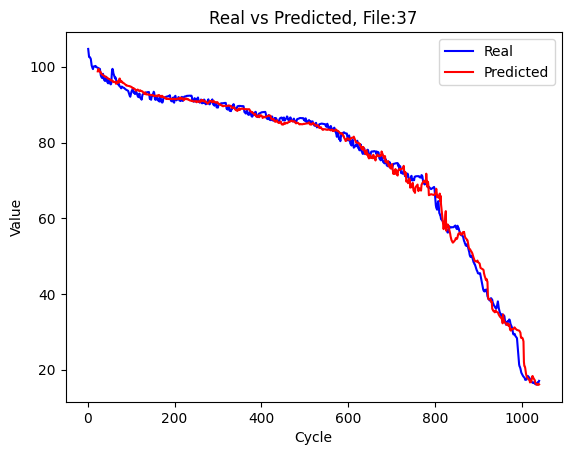

In [14]:
# Predici i valori sul dataset di test
y_pred = model.predict(X_test=X_test)
# y_pred = np.hstack((y_pred, y_cycle))
print(y_pred.shape, y_cycle.shape)
mae = np.abs(y_pred - y_test).mean()
rmse = np.sqrt(np.power((y_pred - y_test),2).mean())
print(y_pred.shape, mae*100, rmse*100)
plt.plot(file_cycle, (file_soh/1.1)*100, label='Real', color='blue')
plt.plot(y_cycle, (y_pred/1.1)*100, label='Predicted', color='red')
plt.title(f'Real vs Predicted, File:{file_number}')
plt.xlabel('Cycle')
plt.ylabel('Value')
plt.legend()
plt.show()